In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import time
from time import sleep
from IPython.display import Image
import sys

In the following, we define some constants and parameters.

In [2]:
mu0 = 4e-7*np.pi
c0 = 299792458
eps0 = 1/(c0**2*mu0)
hbar = 1.05457182e-34
kb = 1.380649e-23
#$\mu$ is dipole matrix element. This is set to e*1.3nm in the paper
mu = 1.60217663e-19*1.3e-9
#Lc is the total length of the 1d photonic lattice
Lc = 1.2e-4
#Lr is the total length of the system including the vaccum part.
Lr = 0.012
#Np is the number of periods of the photonic lattices.
Np = 12
#lp is the length of one period.
lp = Lc/Np
#A is the cross section area of the system. It affect the normalization of the electric field.
A = 1

## Compute Eigenmodes

Define some constants and parameters. Tp is the effective transmission coefficient. The low_kb and high_kb define the range of $k l_p$ we will consider, kbar/$l_p$ is the average wave vector of all the modes we considered. Np is the number of the delta points in the Photonic lattices. L is the dimensionless total length of whole 1d space (scaled by lp=the length of one period of the photonic lattice). 

In [82]:
Tp=1
low_kb = 0
high_kb = 5*np.pi
eta_eff = 2*np.sqrt((1-Tp)/Tp)
kbar = (low_kb + high_kb)/2
Lam = eta_eff/kbar
Np = 12
L=1200

To solve the eigenmodes, we define a function of the wavevector that using the transfer matrix method to construct the boundary condition.

In [1]:
def abNkl(kl):
    z = np.exp(1j*kl)
    z = z.item()
    eta = Lam*kl
    eta = eta.item()
    M = np.matrix([[(1+1j/2*eta)*z,1j/2*eta*z],[-1j/2*eta/z,(1-1j/2*eta)/z]])
    FM = np.linalg.matrix_power(M,Np-1)
    u1 = np.matrix([[1/(2j)*z],[-1/(2j)/z]])
    abNm = np.dot(FM,u1)
    alp = abNm.item(0)
    beta = abNm.item(1)
    fbc = ((1+1j/2*eta)*alp + 1j/2*eta*beta)*z**(L-Np) + (-1j/2*eta*alp + (1-1j/2*eta)*beta)*z**(Np-L)
    return np.real(fbc)

To ensure the eigenmodes in the list are not repeated, we define a function to check if two of them are repeated.

In [84]:
def check_repeat(samples, item, tol):
    count = 0
    repeat_f = False
    while (not repeat_f) and count < len(samples):
        item_ch= samples[count]
        if np.abs(item-item_ch) < tol:
            repeat_f = True
        count += 1
    return repeat_f

To solve the eigenmodes, we make a list of initial guesses and use optimize.root to find the root of the boundary condition output of abNkl. And, we only add the mode to the list if it is not the same with any of the modes in the list. For L=1200, the mode separation is $\pi$/1200~0.0026, so we need to have the separation of the initial guess smaller than this value.

In [85]:
kl = np.linspace(low_kb,high_kb,36000)
ks = []
tol = 1e-7
for k in kl:
    ksol=optimize.root(abNkl,k,tol=1e-13)
    if ksol.success:
        ksc = ksol.x.item()
        kscr = np.round(ksc,13)
        if kscr > low_kb and kscr < high_kb:
            if len(ks)>=1:
                if not check_repeat(ks, kscr, tol):
                    ks.append(kscr)
            else:
                ks.append(kscr)
len(ks)

5999

In order to compute confinement factor, we define two functions to output the value of the eigenmode given the position and the wave vector. The version 2 is better, but we need to compute the coefficients for each parts first (using u_coef_g).

In [127]:
def u_coef_g(kl, Np):
    z = np.exp(1j*kl)
    eta = Lam*kl
    u_coef = np.zeros((Np+1,2), dtype=np.cdouble)
    u_coef[0,0] = -1j/2; u_coef[0,1] = 1j/2
    M = np.matrix([[(1+1j/2*eta)*z,1j/2*eta*z],[-1j/2*eta/z,(1-1j/2*eta)/z]])
    u1 = np.matrix([[1/(2j)*z],[-1/(2j)/z]])
    for i in range(1,Np+1):
        Mp = np.dot(np.linalg.matrix_power(M,i),u1)
        u_coef[i,0] = Mp[0]*z**(-Np); u_coef[i,1] = Mp[1]*z**(Np)
    return u_coef

In [129]:
u_coef_d = {};
for kl in ks:
    u_coef_d[kl] = u_coef_g(kl, Np)

In [154]:
def unklf_v2(kl, ucoef_d, zv):
    n = np.int_(zv) + 1
    if n > Np:
        n = Np + 1
    u_coef_l = ucoef_d[kl]
    u_coef = u_coef_l[n-1]
    return u_coef[0]*np.exp(1j*kl*zv) + u_coef[1]*np.exp(-1j*kl*zv)

In [86]:
def unklf(kl,zv):
    n = np.int_(zv) + 1
    z = np.exp(1j*kl)
    eta = Lam*kl
    M = np.matrix([[(1+1j/2*eta)*z,1j/2*eta*z],[-1j/2*eta/z,(1-1j/2*eta)/z]])
    u1 = np.matrix([[1/(2j)*z],[-1/(2j)/z]])
    if n > 0 and n <= Np:
        FM = np.linalg.matrix_power(M,n-1)
        abNm = np.dot(FM,u1)
        alp = abNm.item(0)/(z**n)
        beta = abNm.item(1)*(z**n)
        un = alp*np.exp(1j*kl*zv) + beta*np.exp(-1j*kl*zv)
    elif n>Np:
        FM = np.linalg.matrix_power(M,Np-1)
        abNm = np.dot(FM,u1)
        alp = abNm.item(0)
        beta = abNm.item(1)
        un = ((1+1j/2*eta)*alp + 1j/2*eta*beta)*z**(zv-Np) + (-1j/2*eta*alp + (1-1j/2*eta)*beta)*z**(Np-zv)    
    return un

We generate a list of two integrations (inside and outside of the photonic lattice) of the square of fields for all eigenmodes. This will be used in the next photon number computation. This computation will take a lot of time, so we use a progress bar to keep track of the progress.

In [179]:
emode_int=[]
count = 0
lks = len(ks)
for klv in ks:
    plv = integrate.quad(lambda x: np.abs(unklf_v2(klv, u_coef_d, x))**2, 0, Np,limit=50000)[0]
    fsv = integrate.quad(lambda x: np.abs(unklf_v2(klv, u_coef_d, x))**2, Np, L, limit=50000)[0]
    emode_int.append([plv,fsv])
    x = count/lks*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('😁'*int(x/10), int(x)))
    sys.stdout.flush()
    count += 1
    sleep(0.0001)

[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁  ] 18%

C:\Users\chihw\AppData\Local\Temp\ipykernel_117196\2395988179.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fsv = integrate.quad(lambda x: np.abs(unklf_v2(klv, u_coef_d, x))**2, Np, L, limit=50000)[0]


[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 99%

In [180]:
len(emode_int)

5999

To impose the normalization condition for the field as in the paper: $$\int_0^L\,dz\,\epsilon(z) u_k^2(z) = \epsilon_0\,,$$ we need to have: $$\int_0^L\,dz\,u_k^2(z) ~+~ \frac{\eta}{\bar{k}}\sum_{i=1}^{N_{pl}}\,u_k^2(z_i) ~=~ 1\,.$$ So, we at first compute the above expression using the non-normalized field: $$\int_0^L\,dz\,\tilde{u}_k^2(z) ~+~ \frac{\eta}{\bar{k}}\sum_{i=1}^{N_{pl}}\,\tilde{u}_k^2(z_i) ~=~ A\,,$$ Then, we normalized the field like: $u_k(z) = \frac{1}{\sqrt{A}}\,\tilde{u}_k(z)$. The normalized $\Gamma_k$ will be: $$\Gamma_k = \frac{1}{A}\,\int_0^{L_c}\,d_z\,\tilde{u}_k^2(z)$$
G_in and G_out are two values recording the renormalized integrations inside and outside of the photonic lattice.

In [102]:
emodes = np.load("Emodes_0_5pi_Tp1.npz")
emodes.files

['ks', 'Gammak', 'emode_int']

In [104]:
ks = emodes["ks"]
Gamma_k = emodes["Gammak"]
emode_int = emodes["emode_int"]

In [181]:
def normal(Tp, ksl, e_int):    
    if len(ksl) == len(e_int):
        Gamma_k = []
        for i in range(len(ksl)):
            if Tp == 1:
                A = e_int[i][0] + e_int[i][1]
            else:
                sum = 0
                for z in range(Np):
                    sum += np.abs(unklf(ksl[i],z+1))**2
                A = e_int[i][0] + e_int[i][1] + Lam*sum
            Gamma_k.append(e_int[i]/A)
    else:
        print("error!")
    return np.array(Gamma_k)

In [184]:
emode_int = np.array(emode_int)
Gamma_k = normal(Tp,ks, emode_int)
G_in = Gamma_k[...,0]
G_out = Gamma_k[...,1]

We save the data generated into a file.

In [191]:
np.savez_compressed("Emodes_0_5pi_Tp1_v2", ks = ks, G_in = G_in, G_out = G_out, emode_int = emode_int) 

In [23]:
emodes = np.load("Emodes_0_5pi_Tp001.npz")
emodes.files

['ks', 'Gammak', 'emode_int']

In [167]:
#data = np.load("Emodes_v3.npz")
#data = dict(data)
#data["Tp_001_kl"] = np.array(ks)
#data["Tp_001_gk"] = np.array(Gamma_k)
#data["Tp_001_int"] = np.array(emode_int)
#np.savez("Emodes_v3.npz",**data)

In [12]:
#np.savez("Emodes_v3.npz",Tp_001_kl=np.array(ks), Tp_001_gk=np.array(Gamma_k), Tp_001_int=np.array(emode_int))

### Generate $(\Omega L_p/c)$-$T_p$ graph

This following function compute the percentage of the energy confined in the photonic lattice.

In [11]:
def energy_ratio(klv):
    plv = integrate.quad(lambda x: np.abs(unklf(klv,x))**2, 0, Np,limit=1000)[0]
    fsv = integrate.quad(lambda x: np.abs(unklf(klv,x))**2, Np, L, limit=1000)[0]
    return plv/(plv+fsv)

We scan the energy ratio for some range of eigenmodes.

In [12]:
for k in range(100,120):
    plv = integrate.quad(lambda x: np.abs(unklf(ks[k],x))**2, 0, Np,limit=1000)[0]
    fsv = integrate.quad(lambda x: np.abs(unklf(ks[k],x))**2, Np, L, limit=1000)[0]
    print("%d modes: %f %f" % (k,plv, fsv))

100 modes: 1.848169 598.055892
101 modes: 1.836255 609.046349
102 modes: 1.823082 616.722674
103 modes: 1.808866 620.956528
104 modes: 1.793838 621.673503
105 modes: 1.778233 618.854577
106 modes: 1.746260 602.812428
107 modes: 1.730373 589.828796
108 modes: 1.714864 573.785128
109 modes: 1.699958 554.930122
110 modes: 1.685866 533.558060
111 modes: 1.672785 510.004254
112 modes: 1.660893 484.639788
113 modes: 1.650348 457.865613
114 modes: 1.641288 430.106090
115 modes: 1.633825 401.802064
116 modes: 1.628046 373.403560
117 modes: 1.624013 345.362215
118 modes: 1.872439 592.630781
119 modes: 1.621761 318.123551


In [26]:
len(emode_int)

6003

In [17]:
crit = 0.1
pl_modes=[]
for i in range(len(ks)):
    ratio = emode_int[i][0]/(emode_int[i][0]+emode_int[i][1])
    if ratio > crit:
        pl_modes.append([Tp,ks[i]])

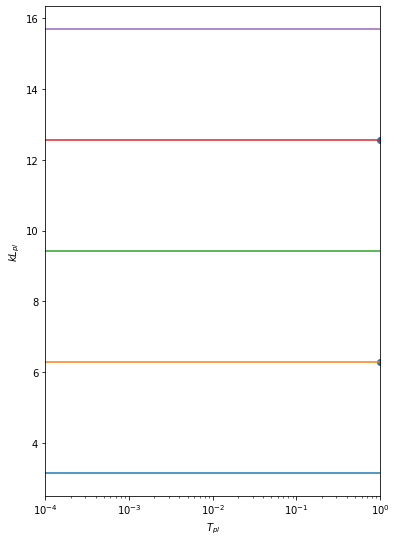

In [18]:
pTpl=np.transpose(pl_modes)
plt.figure(figsize=(6,9))
plt.xscale("log")
plt.xlim(1e-4,1)
plt.xlabel(r"$T_{pl}$")
plt.ylabel(r"$kL_{pl}$")
plt.scatter(pTpl[0],pTpl[1])
plt.plot([np.pi,np.pi])
plt.plot([2*np.pi,2*np.pi])
plt.plot([3*np.pi,3*np.pi])
plt.plot([4*np.pi,4*np.pi])
plt.plot([5*np.pi,5*np.pi])
plt.savefig("Efreq_Tp1_0_5pi_.png",dpi=100)

## Compute photon number

At first, we define some constants and parameters according to the paper

In [198]:
gamma = 1e12
gamma_c = 1e9
gamma_r = 1e13
Lambda_0 = 1e10
omega_0 = 1.6e14
N = 601
Temp_p = 400
Temp = 400
D = 2*mu**2/(hbar*eps0*A*Lc*gamma)

$f_a$ and $f_b$ are two functions related to the thermal relaxation.

In [199]:
def fa(omega_n,T):
    return 1/(1+np.exp(-hbar*omega_n/(kb*T)))
def fb(omega_n,T):
    return np.exp(-hbar*omega_n/(kb*T))/(1+np.exp(-hbar*omega_n/(kb*T)))              

Here we define a function that will give $\frac{d N}{d t}$ after input the initial conditions of $N_a$, $N_b$, $N_k$, eigen modes and temperatures.

In [3]:
def Ndt(Nmati, modes, T, Tp, nw, nn=1):
    
#    start_time = time.time()
    range_a = range(nn); range_ok = range(nn, nn+nw)
    Kernel = np.zeros((nn,nw))
    Ndti = np.zeros(2*nn+nw)
    for n in range_a:
        for k in range_ok:
            L = 1/(1+((modes[n] - modes[k])/gamma)**2)
            Kernel[n,k-nn] = modes[k]*modes[nw+k]*((Nmati[nn+n] - Nmati[n])*Nmati[nn+k] + Nmati[nn+n])*L
    Kernel_sn = np.sum(Kernel, axis=0)
    Kernel_sk = np.sum(Kernel, axis=1)
    for n in range_a:
        Lambda_n = Lambda_0*np.exp(hbar*(omega_0-modes[n])/(kb*Tp))
        Ndti[n] = D*Kernel_sk[n] - Lambda_n*Nmati[n] - gamma_r*(Nmati[n] - N*fa(modes[n],T))
        Ndti[nn+n] =  -D*Kernel_sk[n] + Lambda_n*Nmati[n] - gamma_r*(Nmati[nn+n] - N*fb(modes[n],T))
    for k in range_ok:
        Ndti[nn+k] = D*Kernel_sn[k-nn] - gamma_c*Nmati[nn+k]
    
#    end_time = time.time()
#    print(f'The time used: {end_time - start_time}')
    return Ndti    

In [203]:
emodes = np.load("Emodes_0_5pi_Tp1_v2.npz")
emodes.files

['ks', 'G_in', 'G_out', 'emode_int']

In [204]:
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]

In [205]:
Omega_k = ks/lp*c0
Nki = np.zeros((len(Omega_k)))

Here we assign the values of $\omega_n$ and the initial conditions of $N_a$ and $N_b$.

In [206]:
omega_n = np.linspace(1.2e14,5.2e14,40)
#omega_n = np.array([2e14])
Nani = np.ones(len(omega_n))*N
Nbni = np.zeros(len(omega_n))

To use Ndt function, we join the arrays of $N_a$, $N_b$ and $N_k$ and the arrays of $\omega_n$, $\Omega_k$ and G_in

In [209]:
Ni = np.hstack((Nani, Nbni, Nki))
modes = np.hstack((omega_n, Omega_k, G_in)) 

We define a function to compute $N(t)$ using the Runge-Kutta method. Starting from t=0, we input the final time t and number of steps. And it will take a long time so we use a progress bar to track.

In [213]:
def rk4(Nmati, modes, t, n_steps, r_step, T, Tp, nn=1):
    start_time = time.time()
    h = t/n_steps
    nw = len(Nmati) - 2*nn
    Nat = []
    Nbt = []
    Nkt = []
    for i in range(n_steps):
        k1 = Ndt(Nmati, modes, T, Tp, nw, nn)*h
        Nmatik1 = Nmati + k1/2
        k2 = Ndt(Nmatik1, modes, T, Tp, nw, nn)*h
        Nmatik2 = Nmati + k2/2
        k3 = Ndt(Nmatik2, modes, T, Tp, nw, nn)*h
        Nmatik3 = Nmati + k3
        k4 = Ndt(Nmatik3, modes, T, Tp, nw, nn)*h
        Nmati = Nmati + k1/6 + k2/3 + k3/3 + k4/6
        if (i%r_step) == 0:
            Nat.append(Nmati[:nn])
            Nbt.append(Nmati[nn:2*nn])
            Nkt.append(Nmati[2*nn:])
        x = i/n_steps*100
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %d%%" % ('😁'*int(x/10), int(x)))
        sys.stdout.flush()
        sleep(0.0001)
    end_time = time.time()
    print(f'The time used: {end_time-start_time}')
    return np.array(Nat), np.array(Nbt), np.array(Nkt)  

In [214]:
Na, Nb, Nk = rk4(Ni, modes, 5e-13, 1000, 10, Temp, Temp_p, nn=len(omega_n))

[😁😁😁😁😁😁😁😁😁           ] 99%The time used: 1859.903902053833


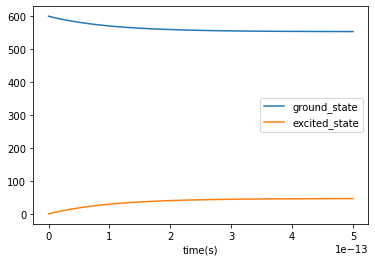

In [216]:
i = 1
tl = np.linspace(0,5e-13,100)
plt.xlabel("time(s)")
plt.plot(tl,Na[...,i], label="ground_state")
plt.plot(tl,Nb[...,i], label="excited_state")
plt.legend()
plt.savefig("Na_Nb_wspread.png")

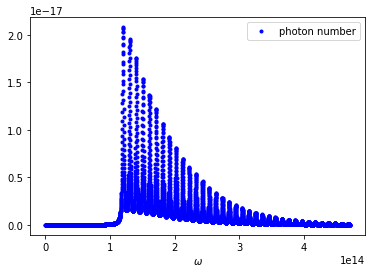

In [217]:
plt.xlabel("$\omega$")
plt.plot(Omega_k,Nk[-1],'b.', label="photon number")
plt.legend()
plt.savefig("Nk_Tp1_n40_ser.png")

In [218]:
np.savez_compressed('Photon_n_0_5pi_Tp1_n40_v2', Nat = Na, Nbt = Nb, Nkt = Nk)

## Compute $S_{in}$ and $S_{out}$

### Define $S_{in}$, $S_{out}$ and plot them

In [13]:
def fa(omega_n,T):
    return 1/(1+np.exp(-hbar*omega_n/(kb*T)))
def fb(omega_n,T):
    return np.exp(-hbar*omega_n/(kb*T))/(1+np.exp(-hbar*omega_n/(kb*T)))   
N = 601
Temp = 400

In [9]:
omega_n = np.linspace(1.2e14,5.2e14,40)

In [3]:
nit_tp1 = np.load('Photon_n_0_5pi_Tp1_n40_v2.npz')
nit_tp001 = np.load('Photon_n_0_5pi_Tp001_n40_v2.npz')
nit_tp001.files

['Nat', 'Nbt', 'Nkt']

In [4]:
emodes_tp1 = np.load('Emodes_0_5pi_Tp1_v2.npz')
emodes_tp001 = np.load('Emodes_0_5pi_Tp001_v2.npz')
emodes_tp001.files

['ks', 'G_in', 'G_out', 'emode_int']

In [5]:
Nat_tp1 = nit_tp1['Nat']
Nbt_tp1 = nit_tp1['Nbt']
Nkt_tp1 = nit_tp1['Nkt']
ks_tp1 = emodes_tp1['ks']
G_in_tp1 = emodes_tp1['G_in']
G_out_tp1 = emodes_tp1['G_out']
Omega_k_tp1 = ks_tp1/lp*c0

In [6]:
Nat_tp001 = nit_tp001['Nat']
Nbt_tp001 = nit_tp001['Nbt']
Nkt_tp001 = nit_tp001['Nkt']
ks_tp001 = emodes_tp001['ks']
G_in_tp001 = emodes_tp001['G_in']
G_out_tp001 = emodes_tp001['G_out']
Omega_k_tp001 = ks_tp001/lp*c0

In [15]:
Naeql = N*fa(omega_n,Temp)

In [44]:
np.max(Nat_tp1 + Nbt_tp1)

601.0000000000022

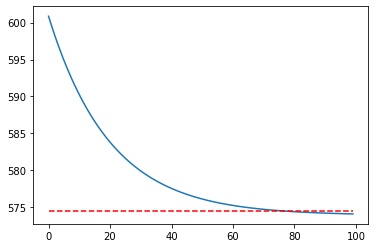

In [24]:
i = 4
Naeq = np.ones(100)*Naeql[i]
plt.plot(Nat_tp001[...,i])
plt.plot(Naeq, 'r--')

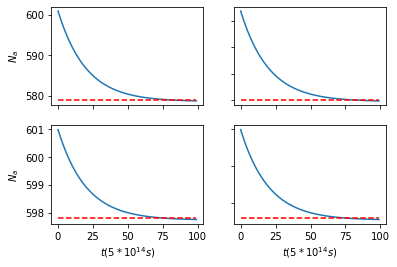

In [38]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(Nat_tp001[...,5])
axs[0, 0].plot(np.ones(100)*Naeql[5], 'r--')
axs[0, 1].plot(Nat_tp001[...,10])
axs[0, 1].plot(np.ones(100)*Naeql[10], 'r--')
axs[1, 0].plot(Nat_tp001[...,15])
axs[1, 0].plot(np.ones(100)*Naeql[15], 'r--')
axs[1, 1].plot(Nat_tp001[...,20])
axs[1, 1].plot(np.ones(100)*Naeql[20], 'r--')

for ax in axs.flat:
    ax.set(xlabel='$t(5*10^{14}s)$', ylabel='$N_a$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('Na_equil_tp001.png',dpi=100)

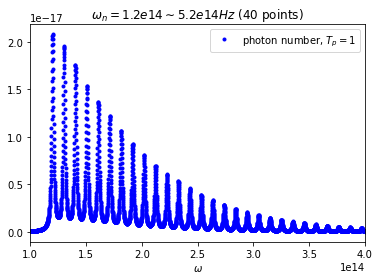

In [80]:
plt.xlim(1e14,4e14)
plt.xlabel(r"$\omega$")
plt.title("$\omega_n=1.2e14 \sim 5.2e14 Hz$ (40 points)")
#plt.ylim(0,3e-17)
plt.plot(Omega_k_tp1,Nkt_tp1[-1],'b.', label='photon number, $T_p=1$')
plt.legend()
plt.savefig("photon_tp1_n40.png", dpi=100)

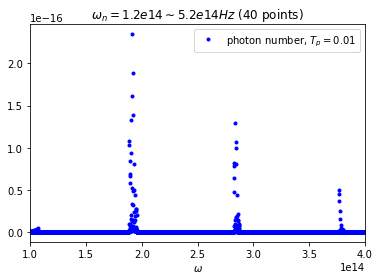

In [79]:
plt.xlim(1e14,4e14)
plt.xlabel(r"$\omega$")
plt.title("$\omega_n=1.2e14 \sim 5.2e14 Hz$ (40 points)")
#plt.ylim(0,3e-17)
plt.plot(Omega_k_tp001,Nkt_tp001[-1],'b.', label='photon number, $T_p=0.01$')
plt.legend()
plt.savefig("photon_tp001_n40.png", dpi=100)

The decay parameter $\gamma_d$ determine how fast the detector's excited atoms decay to ground state. In the paper, it mention that if the value is too big, it will lower the spectrum resolution. But, if it is too small, it will introduce noise. So, we need to try several different values of $\gamma_d$. And, we assign $N_k$ numbers as the $N_k$ at the final time.

In [22]:
gamma_d = 1e11
Nk_tp1 = Nkt_tp1[-1]
Nk_tp001 = Nkt_tp001[-1]

Here we define the Signal_in and Signal_out to compute the strength of the signal inside and outside of the photonic lattice.

In [23]:
def Signal_in(Omega_k,G_in,Nk,omega):
    Lorentz_f=[]
    for i in range(len(Omega_k)):
        Lorentz_f.append(gamma_d/(gamma_d**2+(omega-Omega_k[i])**2))
    return (Omega_k*Nk*G_in*Lorentz_f).sum()

def Signal_out(Omega_k,G_out,Nk,omega):
    Lorentz_f=[]
    for i in range(len(Omega_k)):
        Lorentz_f.append(gamma_d/(gamma_d**2+(omega-Omega_k[i])**2))
    return (Omega_k*Nk*G_out*Lorentz_f).sum()

In [24]:
omega_l = np.linspace(5e13,4e14,1000)
sl_in_tp1 = []
sl_in_tp001 = []
for omega in omega_l:
    sl_in_tp1.append(Signal_in(Omega_k_tp1,G_in_tp1,Nk_tp1,omega))
    sl_in_tp001.append(Signal_in(Omega_k_tp001,G_in_tp001,Nk_tp001,omega))
sl_in_tp1 = np.array(sl_in_tp1)
sl_in_tp001 = np.array(sl_in_tp001)

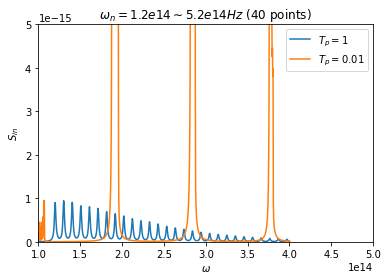

In [63]:
plt.xlabel(r"$\omega$")
plt.ylabel(r"$S_{in}$")
plt.ylim(0,5e-15)
plt.xlim(1e14,5e14)
plt.title("$\omega_n=1.2e14 \sim 5.2e14 Hz$ (40 points)")
plt.plot(omega_l,sl_in_tp1, label="$T_p=1$")
plt.plot(omega_l,sl_in_tp001, label="$T_p=0.01$")
plt.legend(loc=1)
plt.savefig("Sin_0_5pi_n40_v2.png", dpi=100)

In [34]:
omega_l = np.linspace(5e13,4e14,1000)
sl_out_tp1 = []
sl_out_tp001 = []
for omega in omega_l:
    sl_out_tp1.append(Signal_out(Omega_k_tp1,G_out_tp1,Nk_tp1,omega))
    sl_out_tp001.append(Signal_out(Omega_k_tp001,G_out_tp001,Nk_tp001,omega))
sl_out_tp1 = np.array(sl_out_tp1)
sl_out_tp001 = np.array(sl_out_tp001)

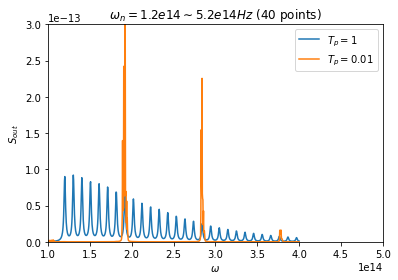

In [61]:
plt.xlabel(r"$\omega$")
plt.ylabel(r"$S_{out}$")
plt.ylim(0,3e-13)
plt.xlim(1e14,5e14)
plt.title("$\omega_n=1.2e14 \sim 5.2e14 Hz$ (40 points)")
plt.plot(omega_l,sl_out_tp1, label="$T_p=1$")
plt.plot(omega_l,sl_out_tp001, label="$T_p=0.01$")
plt.legend()
plt.savefig("Sout_0_5pi_n40_v2.png", dpi=100)